In [1]:
### IMPORTING REQUISITE PACKAGES

from PyQt5 import QtWidgets, QtCore
from PyQt5.QtGui import QPixmap
from pyqtgraph import PlotWidget, plot
import pyqtgraph as pg
import sys  # We need sys so that we can pass argv to QApplication

import detect_heds_module_path
from holoeye import slmdisplaysdk

import numpy as np
import threading
import time
import copy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import csv
import sip
from pypylon import pylon
import cv2
import cProfile, pstats, io
import scipy as sp
from scipy.signal import *
import os
from os.path import isfile, join
import random
from random import randint

[[1.50825556 1.4454685  1.38217994 1.31811607]
 [1.25297262 1.18639955 1.11797973 1.04719755]
 [0.97338991 0.89566479 0.81275556 0.72273425]
 [0.62236849 0.50536051 0.3554212  0.        ]]
[0.         0.50536051 0.72273425 0.89566479 0.97338991 1.04719755
 1.11797973 1.25297262 1.63333709 1.69612416 1.75941271 1.82347658
 1.9551931  2.32883709 2.51922417 2.78617145 3.14159265]


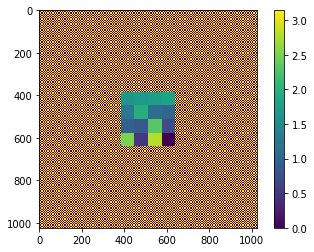

In [2]:
# DEFINING SOME USEFUL FUNCTIONS 

def grating(shape, bin):
    mask = np.zeros(shape)
    for i in range(shape[0]//bin):
        mask[shape[0]*bin:shape[0]*bin + bin, shape[1]*bin:shape[1]*bin + bin] = 128*(i%2)

def grating2(tot_shape, shape, tot_bin, bin):
    data2 = checkerboard(tot_shape, tot_bin)
    data2[(tot_shape[0]-shape[0])//2 : (tot_shape[0]+shape[0])//2, (tot_shape[1]-shape[1])//2:(tot_shape[1]+shape[1])//2] = grating(shape, bin)
    return data2

def checkerboard(shape, bin):
    phase = np.zeros(shape)
    for i in range(shape[0]//bin):
        for j in range(shape[1]//bin):
            phase[i*bin: i*bin + bin, j*bin: j*bin + bin] = 128*((i+j)%2)
    
    return phase

def flip(x, shape, bin, d):
    y = copy.copy(x)
    a = np.random.randint(0, shape[0]//bin, d)
    b = np.random.randint(0, shape[1]//bin, d)
    for i in range(len(a)):
        y[a[i]*bin:a[i]*bin + bin, b[i]*bin:b[i]*bin + bin] = np.pi-y[a[i]*bin:a[i]*bin + bin, b[i]*bin:b[i]*bin + bin]
    return y

def flip2(x, shape, tot_shape, bin, d):
    y = copy.copy(x)
    a = np.random.randint(0, shape[0]//bin, d)
    b = np.random.randint(0, shape[1]//bin, d)
    for i in range(len(a)):
        y[(tot_shape[0]-shape[0])//(2)+a[i]*bin:(tot_shape[0]-shape[0])//(2)+a[i]*bin + bin, (tot_shape[1]-shape[1])//(2)+b[i]*bin:(tot_shape[1]-shape[1])//(2)+b[i]*bin + bin] = np.pi - y[(tot_shape[0]-shape[0])//(2)+a[i]*bin:(tot_shape[0]-shape[0])//(2)+a[i]*bin + bin, (tot_shape[1]-shape[1])//(2)+b[i]*bin:(tot_shape[1]-shape[1])//(2) + b[i]*bin + bin]
    return y

def cost(I_target, I_camera):
    return np.sum((I_target-I_camera)**2)/np.size(I_target)

def cost2(I_target, I_camera):
    return np.sqrt((I_target-I_camera)**2)

def checkerboard2(tot_shape, shape, tot_bin, bin):
    data2 = checkerboard(tot_shape, tot_bin)
    data2[(tot_shape[0]-shape[0])//2 : (tot_shape[0]+shape[0])//2, (tot_shape[1]-shape[1])//2:(tot_shape[1]+shape[1])//2] = checkerboard(shape, bin)
    return data2

def init_state2(tot_shape, tot_bin, shape, bin):
    phase = np.pi*checkerboard2(tot_shape, shape, tot_bin, bin)/128
    phase[(tot_shape[0]-shape[0])//2 : (tot_shape[0]+shape[0])//2, (tot_shape[1]-shape[1])//2:(tot_shape[1]+shape[1])//2] = np.zeros(shape)
    phase = flip2(phase, shape, tot_shape, bin, shape[0]*shape[1]//(bin**2))
    return phase

def deltatarget(shape, extent):
    targ = np.zeros(shape)
    targ[(shape[0]-extent)//2 : (shape[0]+extent)//2, (shape[1]-extent)//2 : (shape[1]+extent)//2] = 255
    return targ
    
def hamiltonian(COST, targ, img):
    x = COST - (np.sum(img**2)/(np.size(img))) - (np.sum(targ**2)/np.size(targ))
    return x
    

def init_state3(tot_shape, shape, total_bin, bin):
    
    data2 = np.pi*checkerboard2(tot_shape, shape, total_bin, bin)/128
    data2[(tot_shape[0]-shape[0])//2 : (tot_shape[0]+shape[0])//2, (tot_shape[1]-shape[1])//2:(tot_shape[1]+shape[1])//2] = 0
    data2 = flip3(data2, tot_shape, shape, bin, shape[0]*shape[1]//(bin**2)//2)
    return data2
    
def reduce(spin, data, count, bins):
    for i in range(0,data.shape[0],bins):
        for j in range(0,data.shape[1],bins):
            spin[(data.shape[0]//bins)*(i//bins) + (j//bins), count] = data[i,j]
            
def rebin(a, bins):
    shape = (a.shape[0]//bins, a.shape[1]//bins)
    sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)
            

def profile(fnc):
    
    """A decorator that uses cProfile to profile a function"""
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

def blank_screen(tot_shape, shape, tot_bin, bin):
    data2 = checkerboard(tot_shape, tot_bin)
    data2[(tot_shape[0]-shape[0])//2 : (tot_shape[0]+shape[0])//2, (tot_shape[1]-shape[1])//2:(tot_shape[1]+shape[1])//2] = 0
    return data2

def spin_tuple(shape, bin_size):
    arr = []
    for i in range(0, shape[0]//bin_size):
        for j in range(0, shape[1]//bin_size):
            arr.append((i,j))
    return arr

def flip3(x, tot_shape, shape, bin, d):
    y = copy.copy(x)
    l = random.sample(spin_arr,d)
    for i in range(d):
        y[(tot_shape[0]-shape[0])//(2)+l[i][0]*bin:(tot_shape[0]-shape[0])//(2)+l[i][0]*bin + bin, (tot_shape[1]-shape[1])//(2)+l[i][1]*bin:(tot_shape[1]-shape[1])//(2)+l[i][1]*bin + bin] = np.pi - y[(tot_shape[0]-shape[0])//(2)+l[i][0]*bin:(tot_shape[0]-shape[0])//(2)+l[i][0]*bin + bin, (tot_shape[1]-shape[1])//(2)+l[i][1]*bin:(tot_shape[1]-shape[1])//(2) + l[i][1]*bin + bin]
    return y

def videostart(spin, phase):
    pathOut = str(spin) + 'x' + str(spin) + '.avi'
    fps = 5
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, phase.shape)
    return out
    
def writevideo(phase, out):
    gray = cv2.normalize(phase, None, 255, 0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    gray_3c = cv2.merge([gray, gray, gray])
    out.write(gray_3c)
    
def videoend(out):
    out.release()
    
def flip_cluster(x, tot_shape, shape, bin, d, cluster_size):
    y = copy.copy(x)
    #l = random.sample(spin_arr,d)
    a = np.random.randint(0, (shape[0]-cluster_size*bin)//(bin), d)
    b = np.random.randint(0, (shape[1]-cluster_size*bin)//bin, d)
    for i in range(d):
        y[(tot_shape[0]-shape[0])//(2)+a[i]*bin:(tot_shape[0]-shape[0])//(2)+a[i]*bin + bin*cluster_size, (tot_shape[1]-shape[1])//(2)+b[i]*bin:(tot_shape[1]-shape[1])//(2)+b[i]*bin + bin*cluster_size] = np.pi - y[(tot_shape[0]-shape[0])//(2)+a[i]*bin:(tot_shape[0]-shape[0])//(2)+a[i]*bin + bin*cluster_size, (tot_shape[1]-shape[1])//(2)+b[i]*bin:(tot_shape[1]-shape[1])//(2) + b[i]*bin + bin*cluster_size]
    return y

def np_init(integers, tot_shape, shape, total_bin, bin):
    zeta = integers/np.max(integers)
    alpha = np.arccos(zeta)
    zetamatrix = np.zeros(shape)
    for i in range(shape[0]//bin):
      for j in range(shape[1]//bin):
        zetamatrix[bin*i:bin*i+bin, bin*j:bin*j+bin] = alpha[i,j]
    print(alpha)
    x = init_state3(tot_shape, shape, total_bin, bin)
    phase = x[(tot_shape[0]-shape[0])//2 : (tot_shape[0]+shape[0])//2, (tot_shape[1]-shape[1])//2:(tot_shape[1]+shape[1])//2]
    idx0 = np.where(phase==0)
    idxpi = np.where(phase==np.pi)
    vec = zetamatrix
    phase[idx0] = phase[idx0]+vec[idx0]
    phase[idxpi] = phase[idxpi] - vec[idxpi]
    x[(tot_shape[0]-shape[0])//2 : (tot_shape[0]+shape[0])//2, (tot_shape[1]-shape[1])//2:(tot_shape[1]+shape[1])//2] = phase
    print(np.unique(x))
    return x

def np_init2(integers, tot_shape, shape, total_bin, bin):
    zeta = integers#/np.max(integers)
    alpha = np.arccos(zeta)
    zetamatrix = np.zeros(shape)
    for i in range(shape[0]//bin):
      for j in range(shape[1]//bin):
        zetamatrix[bin*i:bin*i+bin, bin*j:bin*j+bin] = alpha[i,j]
    #print(alpha)
    x = init_state3(tot_shape, shape, total_bin, bin)
    phase = x[(tot_shape[0]-shape[0])//2 : (tot_shape[0]+shape[0])//2, (tot_shape[1]-shape[1])//2:(tot_shape[1]+shape[1])//2]
    #phase = np.zeros(shape)
    idx0 = np.where(phase==0)
    idxpi = np.where(phase==np.pi)
    vec = zetamatrix
    phase[idx0] = vec[idx0]
    phase[idxpi] = np.pi + vec[idxpi]
    x[(tot_shape[0]-shape[0])//2 : (tot_shape[0]+shape[0])//2, (tot_shape[1]-shape[1])//2:(tot_shape[1]+shape[1])//2] = phase
    #print(np.unique(x))
    return x

def flip_np(x, tot_shape, shape, bin, d):
    y = copy.copy(x)
    l = random.sample(spin_arr,d)
    for i in range(d):
        y[(tot_shape[0]-shape[0])//(2)+l[i][0]*bin:(tot_shape[0]-shape[0])//(2)+l[i][0]*bin + bin, (tot_shape[1]-shape[1])//(2)+l[i][1]*bin:(tot_shape[1]-shape[1])//(2)+l[i][1]*bin + bin] = (np.pi + y[(tot_shape[0]-shape[0])//(2)+l[i][0]*bin:(tot_shape[0]-shape[0])//(2)+l[i][0]*bin + bin, (tot_shape[1]-shape[1])//(2)+l[i][1]*bin:(tot_shape[1]-shape[1])//(2) + l[i][1]*bin + bin])%(2*np.pi)
    return y

number_partitioning = [[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]
spin_arr = spin_tuple((256,256), 64)
trial = np_init(number_partitioning, (1024,1024), (256,256), 4, 64)
plt.imshow(trial)
plt.colorbar()
plt.show()


In [ ]:


# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.binary(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)



def loss_notarget(x):
  ft_x = abs(np.fft.fftshift(np.fft.fft2(x)))**2
  c = np.sum(ft_x)
  ft_x = ft_x/np.sum(ft_x)
  return (ft_x)[N//2,N//2], c

def flip2(x, shape, bin, d):
    y = copy.copy(x)
    a = np.random.randint(0, shape[0]//bin, d)
    b = np.random.randint(0, shape[1]//bin, d)
    for i in range(len(a)):
        y[a[i]*bin:a[i]*bin + bin, b[i]*bin:b[i]*bin + bin] = (y[a[i]*bin:a[i]*bin + bin, b[i]*bin:b[i]*bin + bin]+np.pi)%(2*np.pi)
    return y



loss_arr = []
loss_arr.append(1000000)
fidelity_arr = []
fidelity_arr.append(0.01)
spinflip = []

filepath = ''
number_part = []
x = []
mask = []
eta0 = 0
N = 0
RUN = 0
bins = 2**2
outer_bins = 2**4
size = 0
d = 2**6
numbers_shape = 2**7
numbers = np.random.uniform(0, 1, (numbers_shape,numbers_shape))
numbers = (numbers*1000).astype(int)
print(numbers)
np.savetxt("numbers.csv", numbers, delimiter=',')


class MainWindow(QtWidgets.QMainWindow):

    def __init__(self, *args, **kwargs):
        super(MainWindow, self).__init__(*args, **kwargs)

        self.graphWidget = pg.PlotWidget()
        self.graphWidget.setLabel('left', "Fidelity")
        self.graphWidget.setLabel('bottom', "Iteration number")
        #self.setCentralWidget(self.graphWidget)

        self.X = list(range(100))  # 100 time points
        self.y = [0 for _ in range(100)]  # 100 data points
        #self.y = [randint(0,100) for _ in range(100)]  # 100 data points

        self.graphWidget.setBackground('w')

        pen = pg.mkPen(color=(255, 0, 0))
        #self.data_line =  self.graphWidget.plot(self.X, self.y, pen=pen)

        ###

        self.cmapWidget = pg.ImageView()
        self.imagedata = self.cmapWidget.setImage(np.ones((100,100)))
        #self.imagedata = self.cmapWidget.setImage(np.random.randint(0,100, (100,100)))

        self.cmapWidget.ui.histogram.hide()
        self.cmapWidget.ui.roiBtn.hide()
        self.cmapWidget.ui.menuBtn.hide()

        self.p1 = self.graphWidget.plotItem
        self.p1.setLabels(left='Fidelity')

        self.p2 = pg.ViewBox()
        self.p1.showAxis('right')
        self.p1.scene().addItem(self.p2)
        self.p1.getAxis('right').linkToView(self.p2)
        self.p2.setXLink(self.p1)
        self.p1.getAxis('right').setLabel('Hamiltonian', color='#0000ff')

        #self.imagedata = pg.Image(np.random.randint(0,100, (100,100)))
        widget = QtWidgets.QWidget()
        #self.graphWidget.setGeometry(50,50,100,100)
        self.layout = QtWidgets.QGridLayout()
        self.layout.addWidget(self.graphWidget, 1,0, 7,1)
        self.layout.addWidget(self.cmapWidget, 1,1)

        self.fidelity_disp = QtWidgets.QLabel()
        self.fidelity_disp.setText("Fidelity: "+str(1))
        self.layout.addWidget(self.fidelity_disp)

        #self.buttonwidget = QtWidgets.QPushButton('Click')
        #self.buttonwidget.clicked.connect(self.on_button_clicked)
        #self.buttonwidget.resize(100,40)

        #self.plotbg = pg.plot()
        #self.bg = pg.BarGraphItem(x = [1,2], height = np.asarray([1,4]), width = 0.1, brush ='g')
        #self.plotbg.addItem(self.bg)
        #self.layout.addWidget(self.plotbg,1,3)

        #self.buttonwidget.clicked.connect(threading.Thread(target=self.on_button_clicked).start)
        #self.buttonwidget.show()
        #self.layout.addWidget(self.buttonwidget, 7,1)

        self.buttonwidget2 = QtWidgets.QPushButton('Load File')
        self.buttonwidget2.clicked.connect(self.on_button_clicked2)
        self.buttonwidget2.resize(100,40)
        #self.buttonwidget2.clicked.connect(threading.Thread(target=self.on_button_clicked2).start)
        self.layout.addWidget(self.buttonwidget2, 2, 1)

        self.buttonwidget3 = QtWidgets.QPushButton('Close Window')
        self.buttonwidget3.clicked.connect(self.on_button_clicked3)
        self.buttonwidget3.resize(100,40)
        #self.buttonwidget3.clicked.connect(threading.Thread(target=self.on_button_clicked3).start)
        self.layout.addWidget(self.buttonwidget3, 3,1)


        self.buttonwidget4 = QtWidgets.QPushButton("Start/Continue Run")
        self.buttonwidget4.clicked.connect(self.on_button_clicked4)
        self.buttonwidget4.resize(100,40)
        #self.buttonwidget3.clicked.connect(threading.Thread(target=self.on_button_clicked3).start)
        self.layout.addWidget(self.buttonwidget4, 4,1)

        self.layout.setColumnStretch(0,6)
        self.layout.setColumnStretch(1,4)

        self.buttonwidget5 = QtWidgets.QPushButton("Pause Run")
        self.buttonwidget5.clicked.connect(self.on_button_clicked5)
        self.buttonwidget5.resize(100,40)
        #self.buttonwidget3.clicked.connect(threading.Thread(target=self.on_button_clicked3).start)
        self.layout.addWidget(self.buttonwidget5, 5,1)

        self.buttonwidget6 = QtWidgets.QPushButton("Stop Run")
        self.buttonwidget6.clicked.connect(self.on_button_clicked6)
        self.buttonwidget6.resize(100,40)
        #self.buttonwidget3.clicked.connect(threading.Thread(target=self.on_button_clicked3).start)
        self.layout.addWidget(self.buttonwidget6, 6,1)

        widget.setLayout(self.layout)
        self.setCentralWidget(widget)
        ###

        ###

        # setting title
        self.setWindowTitle("Number Partitioning Solver")

        # setting geometry
        self.setGeometry(100, 100, 800, 800)
        # showing all the widgets
        self.show()

        ###

        # ... init continued ...

    def updateViews(self):
        ## view has resized; update auxiliary views to match
        #global p1, p2, p3
        self.p2.setGeometry(self.p1.vb.sceneBoundingRect())

        ## need to re-update linked axes since this was called
        ## incorrectly while views had different shapes.
        ## (probably this should be handled in ViewBox.resizeEvent)
        self.p2.linkedViewChanged(self.p1.vb, self.p2.XAxis)

    def update_plot_data2(self):
        global x

        x2 = flip2(x,x.shape,bins,1)
        prev_loss, val = loss_notarget(np.exp(1j*((x+mask))))

        loss2,_ = loss_notarget(np.exp(1j*((x2+mask))))
        if loss2 < prev_loss:
            x = x2
            loss_arr.append(loss2)
        else:
            x = x
            loss_arr.append(prev_loss)


        idxp = np.where(x!=0.0)
        idxn = np.where(x==0.0)

        sump = np.sum(abs(mask[idxp]))
        sumn = np.sum(abs(mask[idxn]))
        fidelity_arr.append(abs(sump-sumn)/(sump+sumn))
        time.sleep(0.15)
        thread1 = threading.Thread(target=self.threading_test)
        thread1.start()
        thread1.join()
    
    def update_plot_data(self):
        global x

        if RUN==1:
            x2 = flip2(x,x.shape,bins,1)
            prev_loss, val = loss_notarget(np.exp(1j*((x+mask))))

            loss2,_ = loss_notarget(np.exp(1j*((x2+mask))))
            if loss2 < prev_loss:
                x = x2
                loss_arr.append(loss2)
            else:
                x = x
                loss_arr.append(prev_loss)


            idxp = np.where(x!=0.0)
            idxn = np.where(x==0.0)

            sump = np.sum(abs(mask[idxp]))
            sumn = np.sum(abs(mask[idxn]))
            fidelity_arr.append(abs(sump-sumn)/(sump+sumn))
            time.sleep(0.15)
            thread1 = threading.Thread(target=self.threading_test)
            thread1.start()
            thread1.join()
            
    def update_expt_plot(self):
        global x

        if RUN==1:
            x2 = flip_np(x, size, self.active_area, bins, d)
            error = self.slm.showPhasevalues(x2+mask)
            time.sleep(0.15)
            thread1 = threading.Thread(target=self.threading_test)
            thread1.start()
            thread1.join()
            self.camera.StartGrabbingMax(1)
        
            while self.camera.IsGrabbing():
            # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
                grabResult = self.camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

                # Image grabbed successfully?
                if grabResult.GrabSucceeded():
                    # Access the image data.
                    #img = rebin(grabResult.Array, imgbin)
                    img = grabResult.Array

                else:
                    print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
                grabResult.Release()

            #C1 = cost(target, img)
            C1 = np.sum(img[247:263,247:263])*1.0
            #ham.append(hamiltonian(C1, target, img))
            delE = C1 - loss_arr[-1]
            #print(C1, COST[-1], delE)

            p = np.exp(-1*self.beta[self.count]*delE)                


            if delE <= 0:
                x=x2
                #print("Accepted")
                loss_arr.append(C1)
                spinflip.append(d)
            elif np.random.choice(a=[0,1], p=[p, 1-p])==0:
                x=x2
                loss_arr.append(C1)
                spinflip.append(d)
            else:
                x=x
                loss_arr.append(loss_arr[-1])
                spinflip.append(0)
                #d *= 2

            self.count += 1
            #ham.append(C1)
            #beta -= 0.1
            #beta += 0.1
            #writevideo(data, out)
            final_screen = x[(size[0]-self.active_area[0])//2:(size[0]+self.active_area[0])//2, (size[1]-self.active_area[1])//2:(size[1]+self.active_area[1])//2]


            s1 = np.where(final_screen < np.pi)
            s2 = np.where(final_screen >= np.pi)
            fidelity = (np.sum(number_part[s1])-np.sum(number_part[s2]))/(np.sum(number_part[s1])+np.sum(number_part[s2]))
            fidelity_arr.append(fidelity)
            
           
    
    ###
    def on_button_clicked(self):
        self.alert = QtWidgets.QMessageBox()
        self.alert.setText('You clicked the button!')
        self.alert.exec_()

    def on_button_clicked2(self):
        global filepath
        global number_part
        global x
        global size
        global mask
        global eta0
        global N
        global bins

        filepath = QtWidgets.QFileDialog.getOpenFileName(self, 'Select File')
        self.beta = np.arange(600,0,-0.2)
        self.count=0
        number_part = np.loadtxt(filepath[0], delimiter=",")
        temp = np.zeros((bins*number_part.shape[0],bins*number_part.shape[1]))
        for i in range(number_part.shape[0]):
            for j in range(number_part.shape[1]):
                temp[i*bins:i*bins+bins, j*bins:j*bins+bins] = number_part[i,j]

        number_part=temp
        eta0 = np.max(number_part)
        mask = np.arccos(number_part/eta0)
        N = number_part.shape[0]
        x = (np.sign(np.random.normal(0,1,(N//bins,N//bins))+1e-7)+1)*np.pi/2
        temp = np.zeros((number_part.shape[0],number_part.shape[1]))
        for i in range(number_part.shape[0]//bins):
            for j in range(number_part.shape[1]//bins):
                temp[i*bins:i*bins+bins, j*bins:j*bins+bins] = x[i,j]

        x = temp
        size = x.shape
        self.X=[0]
        print(filepath[0])
        self.camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
        self.camera.Open()
        self.ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
        self.ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

        # Initializes the SLM library
        self.slm = slmdisplaysdk.SLMDisplay()

        # Check if the library implements the required version
        if not self.slm.requiresVersion(2):
            exit(1)

        # Detect SLMs and open a window on the selected SLM
        error = self.slm.open()
        assert error == self.ErrorCode.NoError, self.slm.errorString(error)
        from showSLMPreview import showSLMPreview
        # Reserve memory for the data:
        dataWidth = self.slm.width_px
        dataHeight = self.slm.height_px
        
        data = slmdisplaysdk.createFieldUChar(1024,1024)
        
        print("shape is: ", data.shape)
        print("dataWidth = " + str(dataWidth))
        print("dataHeight = " + str(dataHeight))

        self.active_area = (2**9,2**9)
        self.spin_arr = spin_tuple(self.active_area, bins)

        # Calculate the data:
        #data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
        #data = init_state(data.shape, bins)
        #data = init_state2(data.shape, outer_bins, active_area, bins)
        #data = init_state3(data.shape, active_area, outer_bins, bins)
        
        error = self.slm.showPhasevalues(x+mask)
        print("Random distribution shown on SLM")
        return filepath

    def on_button_clicked3(self):
        print("Closing Window")
        self.close()

    def on_button_clicked4(self):
        global RUN
        global x
        RUN=1
        print("Starting Run")
        
        #while RUN==1:
            #self.update_plot_data2()

        self.timer = QtCore.QTimer()
        self.timer.setInterval(1)
        #self.timer.timeout.connect(self.update_plot_data)
        self.timer.timeout.connect(self.update_expt_plot)
        
        self.timer.start()


    def on_button_clicked5(self):
        global RUN
        RUN=0
        #final_cmap = pg.ColorMap(pos=,color=colors)
        #self.cmapWidget.setColorMap(final_cmap)
        #self.cmapWidget.setImage(2*final_mask/np.pi)

    def on_button_clicked6(self):
        global RUN
        RUN=0
        self.layout.removeWidget(self.cmapWidget)
        sip.delete(self.cmapWidget)
        self.cmapWidget = None
        #self.layout.removeWidget(self.cmapWidget)
        idxp1 = np.where(x!=0.0)
        idxn1 = np.where(x==0.0)
        
        
        final_mask = np.zeros(mask.shape)
        final_mask[idxp1] = mask[idxp1]
        final_mask[idxn1] = -1*mask[idxn1]

        # a figure instance to plot on
        self.figure = plt.figure(figsize=(6,6))

        # this is the Canvas Widget that
        # displays the 'figure'it takes the
        # 'figure' instance as a parameter to __init__
        self.canvas = FigureCanvas(self.figure)

        # this is the Navigation widget
        # it takes the Canvas widget and a parent
        self.toolbar = NavigationToolbar(self.canvas, self)
        # clearing old figure
        self.figure.clear()

        # create an axis
        ax = self.figure.add_subplot(111)

        # plot data
        ax.imshow(final_mask, cmap=mymap)

        # refresh canvas
        self.canvas.draw()
        # adding tool bar to the layout
        self.layout.addWidget(self.toolbar)

        # adding canvas to the layout
        self.layout.addWidget(self.canvas, 1,1)
        
        self.camera.Close()

        # If your IDE terminates the python interpreter process after the script is finished, the SLM content
        # will be lost as soon as the script finishes.
        # You may insert further code here.
        self.slm.close()
        # Wait until the SLM process is closed:
        error = self.slm.utilsWaitUntilClosed()
        assert error == self.ErrorCode.NoError, self.slm.errorString(error)
        # Unloading the SDK may or may not be required depending on your IDE:
        self.slm = None

    def threading_test(self):
        self.X.append(self.X[-1] + 1)  # Add a new value 1 higher than the last.
        #self.X = self.X[1:] # Remove the first X element.
        #self.X.pop(0)

        self.y = fidelity_arr
        #self.y.append(randint(0,100))  # Add a new random value.
        self.fidelity_disp.setText("Fidelity: "+str(fidelity_arr[-1]))
        self.cmapWidget.setImage(x*128/np.pi)

        #self.p2.setGeometry(self.graphWidget.vb.sceneBoundingRect())
        #self.p2.linkedViewChanged(self.graphWidget.vb, self.p2.XAxis)
        self.updateViews()

        #self.data_line.setData(self.X, self.y)  # Update the data.
        self.p1.plot(self.y)
        self.p2.addItem(pg.PlotCurveItem(loss_arr, pen='b'))

    ###


app = QtWidgets.QApplication(sys.argv)
w = MainWindow()
###

###
w.show()
sys.exit(app.exec_())

[[158 742 808 ...  39   2 721]
 [943 269 741 ... 670 504 714]
 [153  50 575 ... 227 595 965]
 ...
 [806 437 463 ... 438 631 409]
 [563 726 180 ... 248 102 812]
 [362 115 225 ... 319 162 849]]
C:/Users/Ramesh/numbers.csv
shape is:  (1024, 1024)
dataWidth = 1920
dataHeight = 1080
Random distribution shown on SLM
Starting Run


ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

Starting Run


ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

ValueError: Sample larger than population or is negative

In [1]:
from PyQt5 import QtWidgets, QtCore
from pyqtgraph import PlotWidget, plot
import pyqtgraph as pg
import sys  # We need sys so that we can pass argv to QApplication
import os
from random import randint
import numpy as np
import threading
import time
import copy
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas 
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
import sip

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.binary(np.linspace(0., 1, 128))
colors2 = plt.cm.gist_heat_r(np.linspace(0, 1, 128))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)



def loss_notarget(x):
  ft_x = abs(np.fft.fftshift(np.fft.fft2(x)))**2
  c = np.sum(ft_x)
  ft_x = ft_x/np.sum(ft_x)
  return (ft_x)[N//2,N//2], c

def flip2(x, shape, bin, d):
    y = copy.copy(x)
    a = np.random.randint(0, shape[0]//bin, d)
    b = np.random.randint(0, shape[1]//bin, d)
    for i in range(len(a)):
        y[a[i]*bin:a[i]*bin + bin, b[i]*bin:b[i]*bin + bin] = (y[a[i]*bin:a[i]*bin + bin, b[i]*bin:b[i]*bin + bin]+np.pi)%(2*np.pi)
    return y



loss_arr = []
fidelity_arr = []
fidelity_arr.append(0.01)


filepath = ''
number_part = []
x = []
mask = []
eta0 = 0
N = 0
RUN = 0
bins = 5




class MainWindow(QtWidgets.QMainWindow):

    def __init__(self, *args, **kwargs):
        super(MainWindow, self).__init__(*args, **kwargs)

        self.graphWidget = pg.PlotWidget()
        #self.setCentralWidget(self.graphWidget)
        
        self.X = list(range(100))  # 100 time points
        self.y = [randint(0,100) for _ in range(100)]  # 100 data points

        self.graphWidget.setBackground('w')

        pen = pg.mkPen(color=(255, 0, 0))
        self.data_line =  self.graphWidget.plot(self.X, self.y, pen=pen)
        
        ###
        self.cmapWidget = pg.ImageView()
        self.imagedata = self.cmapWidget.setImage(np.random.randint(0,100, (100,100)))
        widget = QtWidgets.QWidget()
        #self.graphWidget.setGeometry(50,50,100,100)
        self.layout = QtWidgets.QGridLayout()
        self.layout.addWidget(self.graphWidget, 1,0, 7,1)
        self.layout.addWidget(self.cmapWidget, 1,1)
        self.buttonwidget = QtWidgets.QPushButton('Click')
        self.buttonwidget.clicked.connect(self.on_button_clicked)
        self.buttonwidget.resize(100,40)
        #self.buttonwidget.clicked.connect(threading.Thread(target=self.on_button_clicked).start)
        #self.buttonwidget.show()
        self.layout.addWidget(self.buttonwidget, 7,1)
        
        self.buttonwidget2 = QtWidgets.QPushButton('Load File')
        self.buttonwidget2.clicked.connect(self.on_button_clicked2)
        self.buttonwidget2.resize(100,40)
        #self.buttonwidget2.clicked.connect(threading.Thread(target=self.on_button_clicked2).start)
        self.layout.addWidget(self.buttonwidget2, 2, 1)
        
        self.buttonwidget3 = QtWidgets.QPushButton('Close Window')
        self.buttonwidget3.clicked.connect(self.on_button_clicked3)
        self.buttonwidget3.resize(100,40)
        #self.buttonwidget3.clicked.connect(threading.Thread(target=self.on_button_clicked3).start)
        self.layout.addWidget(self.buttonwidget3, 3,1)
        
        
        self.buttonwidget4 = QtWidgets.QPushButton("Start/Continue Run")
        self.buttonwidget4.clicked.connect(self.on_button_clicked4)
        self.buttonwidget4.resize(100,40)
        #self.buttonwidget3.clicked.connect(threading.Thread(target=self.on_button_clicked3).start)
        self.layout.addWidget(self.buttonwidget4, 4,1)
        
        self.layout.setColumnStretch(0,6)
        self.layout.setColumnStretch(1,4)
        
        self.buttonwidget5 = QtWidgets.QPushButton("Pause Run")
        self.buttonwidget5.clicked.connect(self.on_button_clicked5)
        self.buttonwidget5.resize(100,40)
        #self.buttonwidget3.clicked.connect(threading.Thread(target=self.on_button_clicked3).start)
        self.layout.addWidget(self.buttonwidget5, 5,1)
        
        self.buttonwidget6 = QtWidgets.QPushButton("Stop Run")
        self.buttonwidget6.clicked.connect(self.on_button_clicked6)
        self.buttonwidget6.resize(100,40)
        #self.buttonwidget3.clicked.connect(threading.Thread(target=self.on_button_clicked3).start)
        self.layout.addWidget(self.buttonwidget6, 6,1)
        
        widget.setLayout(self.layout)
        self.setCentralWidget(widget)
        ###
        
        ###
        
        # setting title 
        self.setWindowTitle("Number Partitioning Solver") 
  
        # setting geometry 
        self.setGeometry(100, 100, 800, 800) 
        # showing all the widgets 
        self.show() 
  
        ###
        
        # ... init continued ...
        

    def update_plot_data(self):
        global x
        
        if RUN==1:
            x2 = flip2(x,x.shape,bins,1)
            prev_loss, val = loss_notarget(np.exp(1j*((x+mask))))
            
            loss2,_ = loss_notarget(np.exp(1j*((x2+mask))))
            if loss2 < prev_loss:
                x = x2
                loss_arr.append(loss2)
            else:
                x = x
                loss_arr.append(prev_loss)


            idxp = np.where(x!=0.0)
            idxn = np.where(x==0.0)

            sump = np.sum(abs(mask[idxp]))
            sumn = np.sum(abs(mask[idxn]))
            fidelity_arr.append(abs(sump-sumn)/(sump+sumn))
            time.sleep(0.15)
            thread1 = threading.Thread(target=self.threading_test)
            thread1.start()
            thread1.join()
            #self.X.append(self.X[-1] + 1)  # Add a new value 1 higher than the last.
            
            #self.X = self.X[1:] # Remove the first X element.
            #self.X.pop(0)
           
            #self.y = fidelity_arr
            
            #self.y.append(randint(0,100))  # Add a new random value.
            
            #self.cmapWidget.setImage(x*128/np.pi)
            
            #self.data_line.setData(self.X, self.y)  # Update the data.
        
    ###
    def on_button_clicked(self):
        self.alert = QtWidgets.QMessageBox()
        self.alert.setText('You clicked the button!')
        self.alert.exec_()
    
    def on_button_clicked2(self):
        global filepath
        global number_part
        global x
        global mask
        global eta0
        global N
        global bins
        
        filepath = QtWidgets.QFileDialog.getOpenFileName(self, 'Select File')
        print(filepath[0])
        number_part = np.loadtxt(filepath[0], delimiter=",")
        temp = np.zeros((bins*number_part.shape[0],bins*number_part.shape[1]))
        for i in range(number_part.shape[0]):
            for j in range(number_part.shape[1]):
                temp[i*bins:i*bins+bins, j*bins:j*bins+bins] = number_part[i,j]

        number_part=temp
        eta0 = np.max(number_part)
        mask = np.arccos(number_part/eta0)
        N = number_part.shape[0]
        x = (np.sign(np.random.normal(0,1,(N//bins,N//bins))+1e-7)+1)*np.pi/2
        temp = np.zeros((number_part.shape[0],number_part.shape[1]))
        for i in range(number_part.shape[0]//bins):
            for j in range(number_part.shape[1]//bins):
                temp[i*bins:i*bins+bins, j*bins:j*bins+bins] = x[i,j]

        x = temp
        self.X=[0]
        
        return filepath
    
    def on_button_clicked3(self):
        print("Closing Window")
        self.close()
        
    def on_button_clicked4(self):
        global RUN
        global x
        RUN=1
        
        self.timer = QtCore.QTimer()
        self.timer.setInterval(1)
        
        self.timer.timeout.connect(self.update_plot_data)
        
        #self.timer.timeout.connect()
        self.timer.start()
        
        
    def on_button_clicked5(self):
        global RUN
        RUN=0
               
        
        #final_cmap = pg.ColorMap(pos=,color=colors)
        #self.cmapWidget.setColorMap(final_cmap)
        #self.cmapWidget.setImage(2*final_mask/np.pi)
    
    def on_button_clicked6(self):
        global RUN
        RUN=0
        self.layout.removeWidget(self.cmapWidget)
        sip.delete(self.cmapWidget)
        self.cmapWidget = None
        #self.layout.removeWidget(self.cmapWidget)
        idxp1 = np.where(x!=0.0)
        idxn1 = np.where(x==0.0)
        final_mask = np.zeros(mask.shape)
        final_mask[idxp1] = mask[idxp1]
        final_mask[idxn1] = -1*mask[idxn1]

        # a figure instance to plot on 
        self.figure = plt.figure() 
   
        # this is the Canvas Widget that  
        # displays the 'figure'it takes the 
        # 'figure' instance as a parameter to __init__ 
        self.canvas = FigureCanvas(self.figure) 
   
        # this is the Navigation widget 
        # it takes the Canvas widget and a parent 
        self.toolbar = NavigationToolbar(self.canvas, self)
        # clearing old figure 
        self.figure.clear() 
   
        # create an axis 
        ax = self.figure.add_subplot(111) 
   
        # plot data 
        ax.imshow(final_mask, cmap=mymap) 
   
        # refresh canvas 
        self.canvas.draw()
        # adding tool bar to the layout 
        self.layout.addWidget(self.toolbar) 
           
        # adding canvas to the layout 
        self.layout.addWidget(self.canvas, 1,1)
        
    def threading_test(self):
        self.X.append(self.X[-1] + 1)  # Add a new value 1 higher than the last.
        #self.X = self.X[1:] # Remove the first X element.
        #self.X.pop(0)
           
        self.y = fidelity_arr
        #self.y.append(randint(0,100))  # Add a new random value.
        self.cmapWidget.setImage(x*128/np.pi)
            
        self.data_line.setData(self.X, self.y)  # Update the data.
           
    ###


app = QtWidgets.QApplication(sys.argv)
w = MainWindow()
###

###
w.show()
sys.exit(app.exec_())

C:/Users/Ramesh/numbers.csv
Closing Window


SystemExit: 0

C:\Users\Ramesh\Downloads\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [6]:
w.camera.Close()